### Regression for Count Data

In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

##### 1. Load merged data

In [2]:
covid_final = pd.read_csv('PCA_final.csv')
display(covid_final.head())

,date,location_key,inc_case,inc_hosp,inc_death,sni_covid19_vaccination,liberalism,children,adult,elderly,...,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,population,PC1,PC2,PC3
0,2021-01,Alabama,112124.00000,1.37115,1.58411,0.03257,0.00000,-0.23195,-0.23737,-0.19908,...,-1.15483,-1.23961,-1.01067,-0.71011,-0.40302,1.14987,-0.21577,-2.39642,-0.26211,-0.15532
1,2021-01,Alaska,8604.00000,-0.53724,-0.53990,1.08065,1.00000,-0.75511,-0.76235,-0.84978,...,-1.25898,-1.39978,-0.90495,-1.31684,-0.91324,1.93992,-0.21577,-3.19803,0.41715,0.06795
2,2021-01,Arizona,262750.00000,2.36689,2.94438,1.49213,1.00000,0.13510,0.05954,0.16618,...,-1.63091,-1.78502,-1.15354,-0.30389,-1.66963,2.10521,-0.21577,-3.49872,0.56295,-1.17229
3,2021-01,Arkansas,80418.00000,0.28174,0.46637,0.24792,0.00000,-0.45889,-0.48428,-0.47422,...,-1.13139,-1.28393,-0.87468,-0.39383,-0.12446,1.09266,-0.21577,-2.13154,-0.50374,-0.22359
4,2021-01,California,1180351.00000,10.20692,11.82153,1.09815,1.00000,4.44981,4.49157,4.08748,...,-2.56788,-2.01260,-1.05074,-1.86161,-2.43006,2.87131,-0.21577,-5.16172,1.48841,-0.31035


In [3]:
# Check if 'inc_case' column has any negative values
negative_values = covid_final[covid_final['inc_case'] < 0]
if not negative_values.empty:
    print("Negative values found in 'inc_case' column:")
    print(negative_values)
else:
    print("No negative values found in 'inc_case' column.")

No negative values found in 'inc_case' column.


##### 2. Explore the distribution of inc_case

In [4]:
print(covid_final['inc_case'].dropna().astype(int).head(1000).to_list())

[112124, 8604, 262750, 80418, 1180351, 71251, 77280, 23078, 449001, 274607, 26876, 190599, 133102, 44317, 64532, 107563, 100777, 17621, 87296, 171758, 92811, 54283, 69167, 96464, 14272, 29297, 61218, 25429, 231697, 36312, 488784, 233224, 6225, 228113, 110082, 34069, 234837, 32372, 150893, 11107, 164503, 693232, 81352, 4865, 172644, 74685, 40163, 84975, 8558, 37101, 3995, 60307, 24808, 255989, 34009, 29923, 8966, 190093, 97943, 1711, 8447, 62284, 36080, 17160, 19175, 42729, 31316, 5324, 28552, 58320, 36695, 22971, 19901, 25517, 6127, 9536, 15982, 9804, 94421, 11349, 227342, 111579, 2223, 73373, 37212, 12898, 89594, 11184, 75287, 4223, 49541, 286097, 25396, 3267, 72093, 27126, 11240, 25902, 2646, 21389, 3898, 23000, 10665, 92843, 29985, 25264, 7184, 135380, 50314, 2007, 8302, 50280, 22211, 13284, 6912, 20362, 14477, 5161, 25440, 47876, 77632, 30053, 10329, 62504, 4239, 7602, 9410, 7579, 105181, 5999, 204041, 47243, 2758, 44449, 13169, 8422, 80024, 10153, 33042, 4788, 32474, 128411, 13405

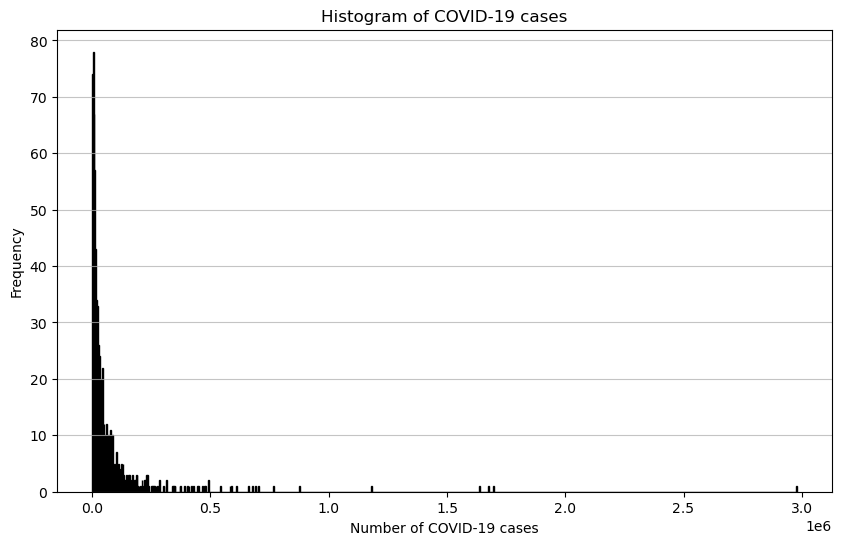

In [5]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(covid_final['inc_case'], bins=1000, color='skyblue', edgecolor='black')
plt.title('Histogram of COVID-19 cases')
plt.xlabel('Number of COVID-19 cases')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

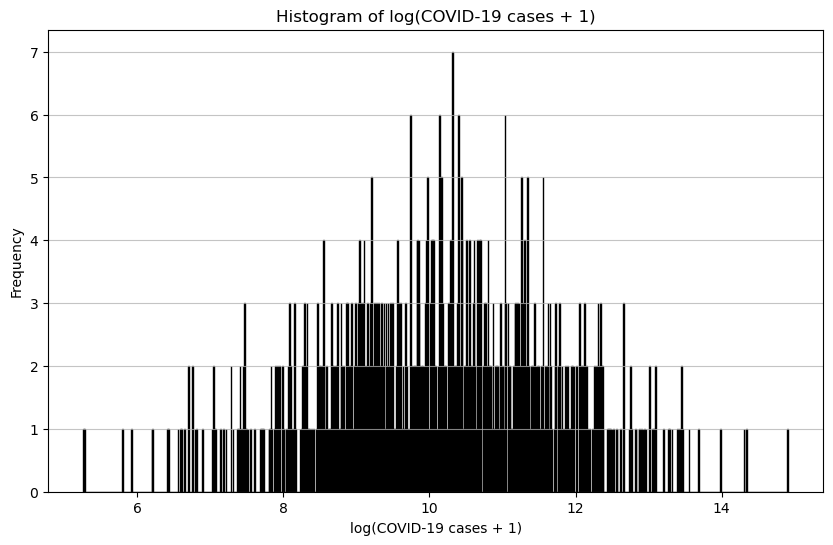

In [6]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(np.log(covid_final['inc_case']+1), bins=1000, color='skyblue', edgecolor='black')
plt.title('Histogram of log(COVID-19 cases + 1)')
plt.xlabel('log(COVID-19 cases + 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [7]:
X = covid_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                 'PC1', 'PC2', 'PC3', 'inc_hosp', 'inc_case', 'location_key', 'date', 'children', 'adult', 'elderly', 'population']]
X_cleaned = X.dropna(axis=0, how='any')

y_cleaned = X_cleaned['inc_case']
y_log_cleaned = np.log(X_cleaned['inc_case']+1)
X_cleaned = X_cleaned.drop(columns=['inc_case'])

In [8]:
X_cleaned['date'] = pd.to_datetime(covid_final['date'], format='%Y-%m')
X_encoded = pd.get_dummies(X_cleaned, columns=['location_key'], drop_first=True).astype(int)

In [9]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded), columns=X_encoded.columns, index=X_encoded.index)

In [10]:
X_encoded_with_const = sm.add_constant(X_train_scaled)

#### Linear Regression

In [11]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_5953/532582492.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     26.41
Date:                Mon, 27 May 2024   Prob (F-statistic):          2.47e-148
Time:                        19:58:36   Log-Likelihood:                -11006.
No. Observations:                 849   AIC:                         2.213e+04
Df Residuals:                     789   BIC:                         2.242e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [12]:
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_encoded_with_const, y_cleaned, test_size=0.3, random_state=42)

# Linear regression model
model = sm.OLS(y_train, X_train).fit()

# Get predictions
y_predictions = model.predict(X_test)

# Check model accuracy
mse = mean_squared_error(y_test, y_predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 94976.58394501523


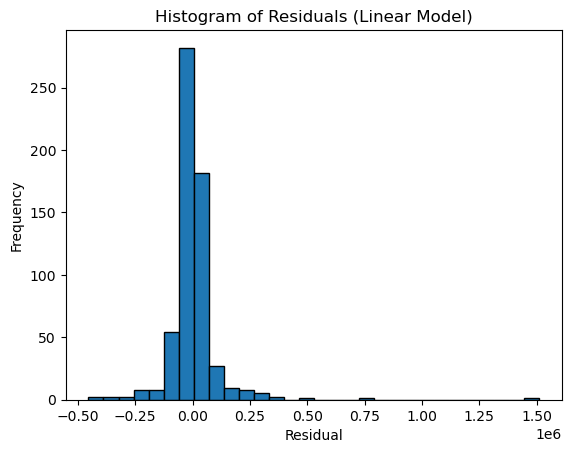

In [13]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Model)')
plt.show()

In [14]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/scipy/stats/_multivariate.py:758: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


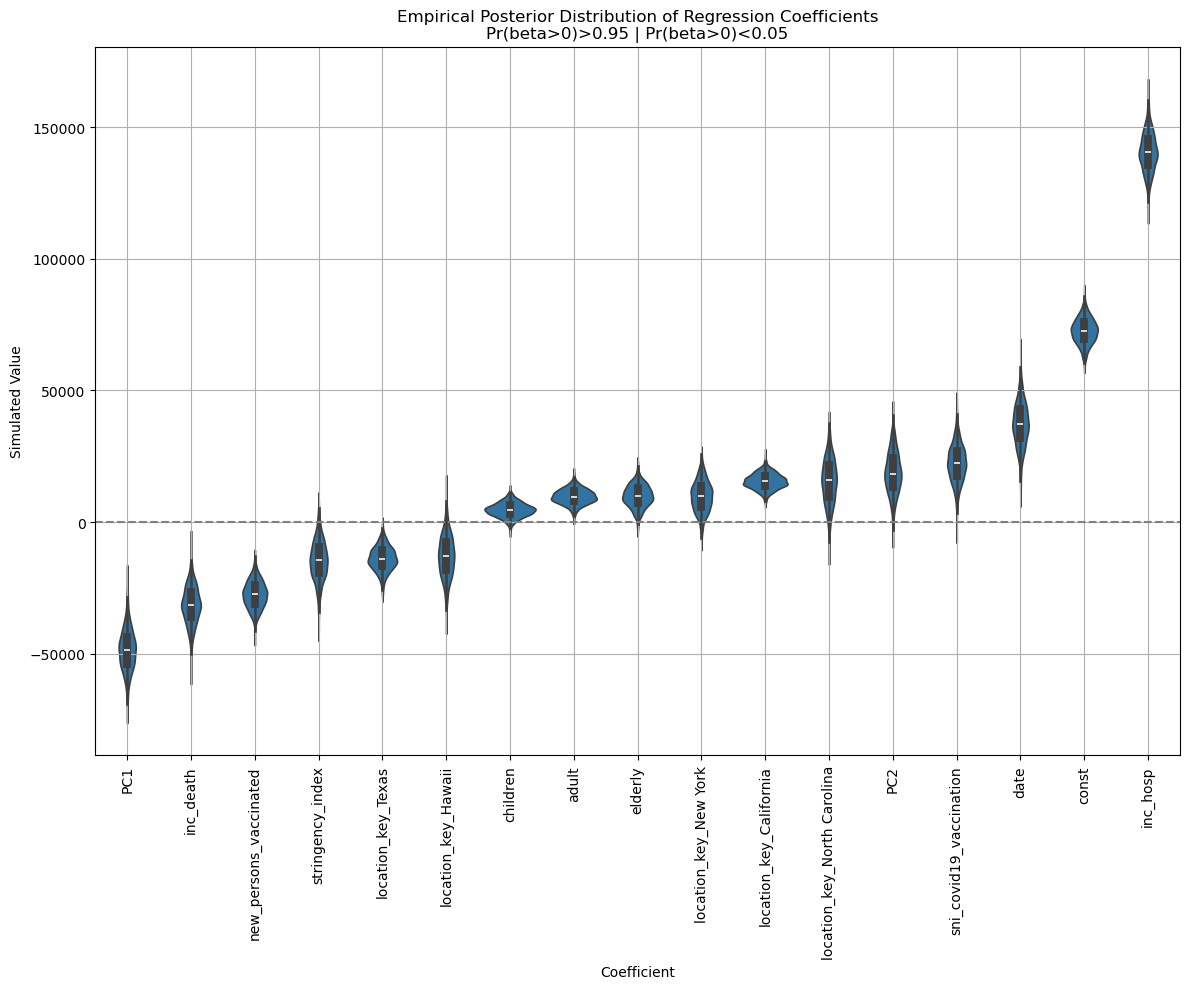

In [15]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')

# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [16]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [17]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.dot(X_encoded_with_const, beta_simulation)
    predicted_counts[i] = np.random.normal(predicted_rate,np.sqrt(model.scale))

In [18]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

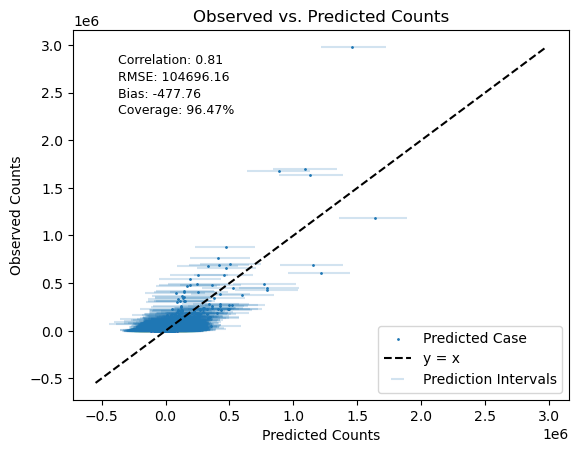

In [19]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


#### Log-linear Regression

In [20]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_log_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_5953/598896821.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     25.70
Date:                Mon, 27 May 2024   Prob (F-statistic):          2.24e-145
Time:                        19:58:38   Log-Likelihood:                -1099.9
No. Observations:                 849   AIC:                             2320.
Df Residuals:                     789   BIC:                             2604.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

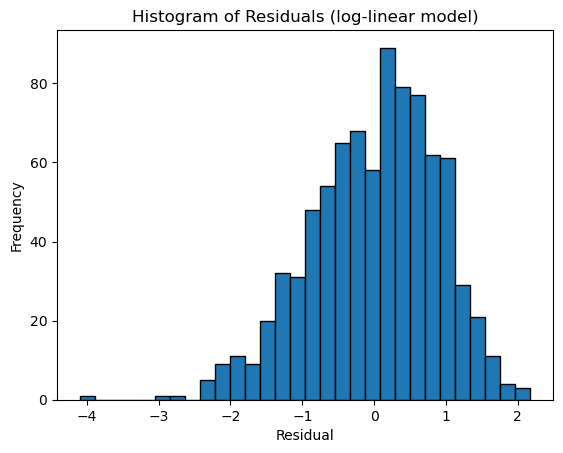

In [21]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (log-linear model)')
plt.show()

In [22]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

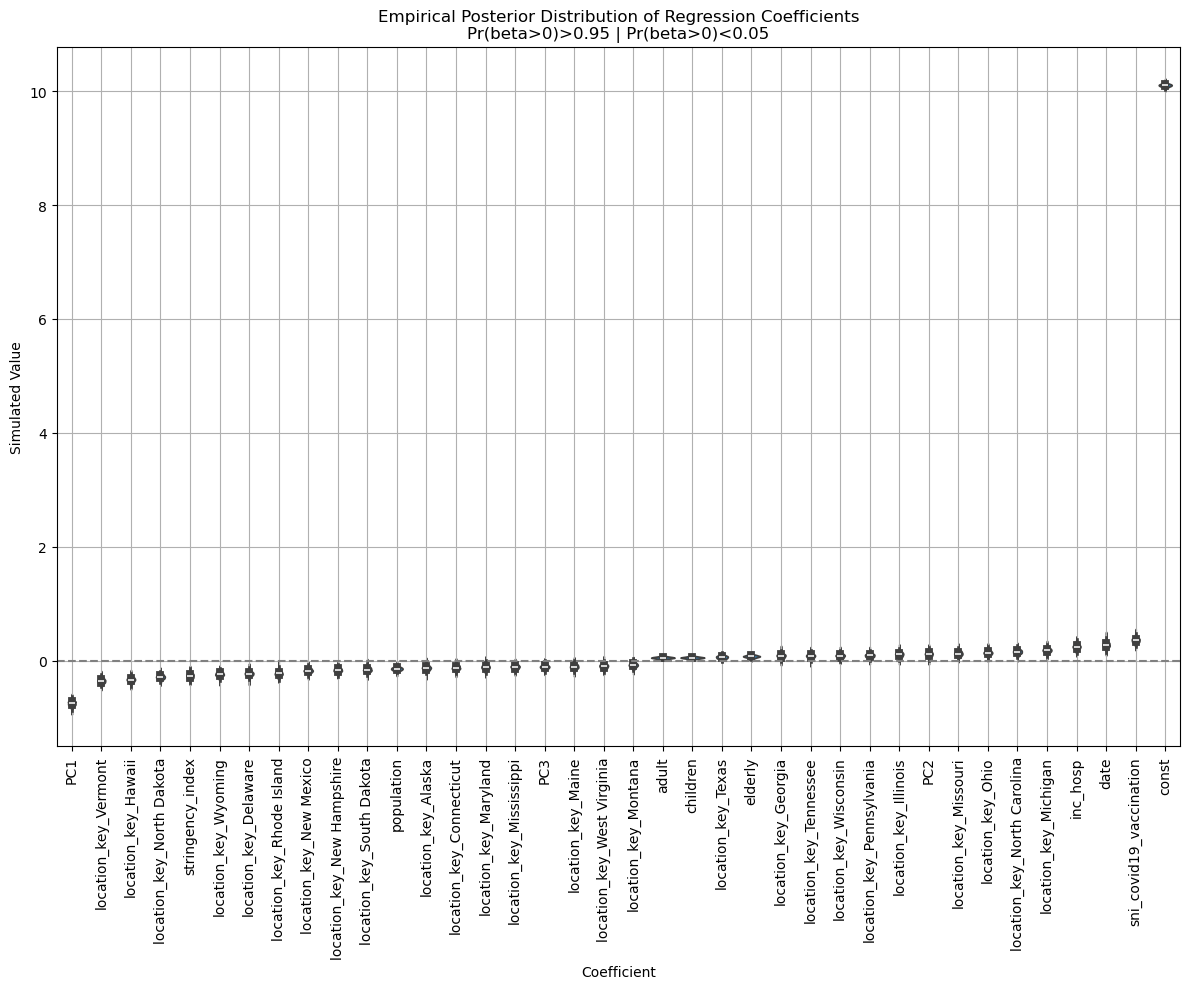

In [23]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [24]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [25]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_log_rate = np.dot(X_encoded_with_const, beta_simulation)
    # Simulate from the posterior-predictive distirbution 
    # If we do nothing to `rate`, this will spit out an error because some rates will be `negativ
    predicted_counts[i] = np.exp(np.random.normal(predicted_log_rate,np.sqrt(model.scale)))

In [26]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

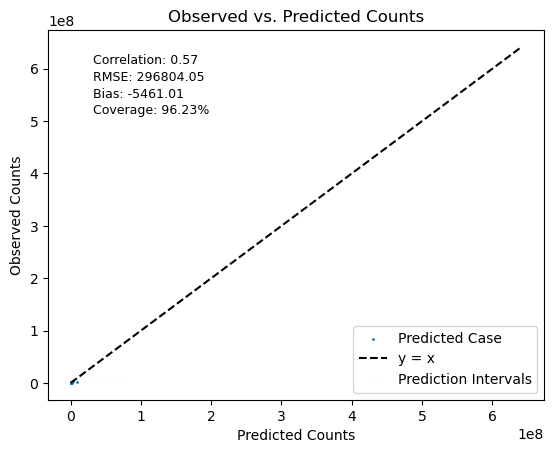

In [27]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.01, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


#### Poisson Regression

In [28]:
from statsmodels.api import GLM, Poisson

In [29]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_5953/453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                 Generalized Linear Model Regression Results                  
Dep. Variable:               inc_case   No. Observations:                  849
Model:                            GLM   Df Residuals:                      789
Model Family:                 Poisson   Df Model:                           59
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1673e+07
Date:                Mon, 27 May 2024   Deviance:                   2.3335e+07
Time:                        19:58:41   Pearson chi2:                 2.36e+07
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [30]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

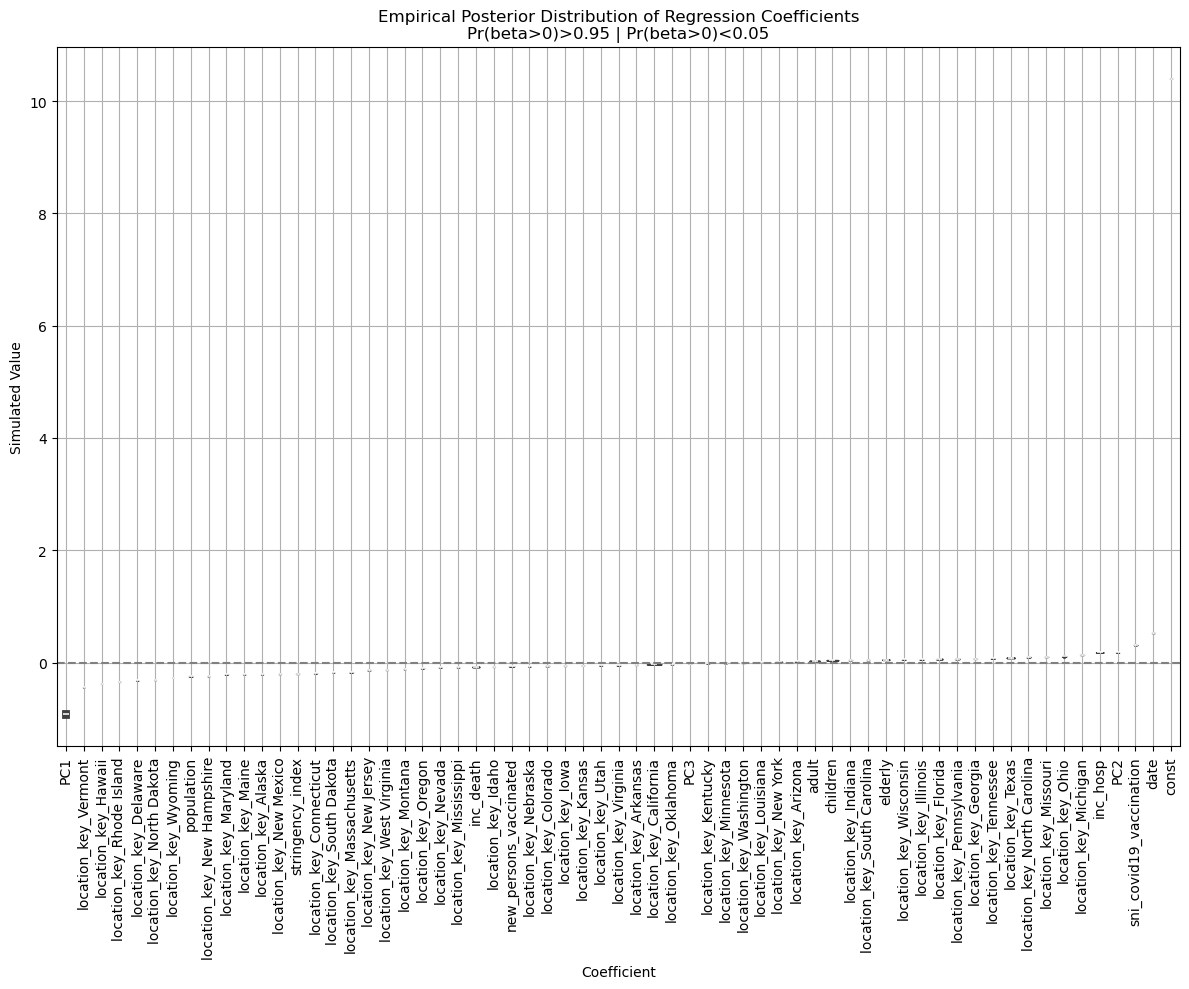

In [31]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [32]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [33]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

In [34]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

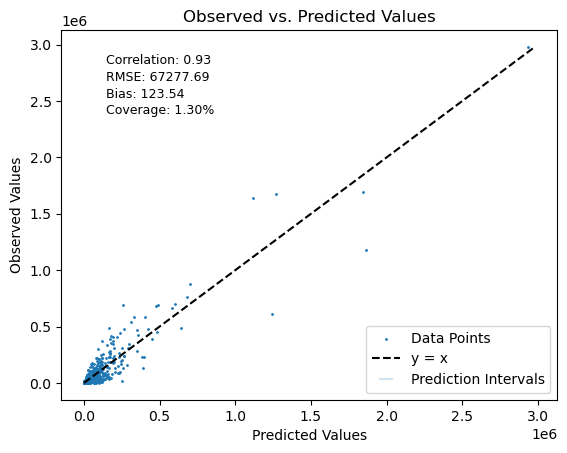

In [35]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()